# Import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_hub

In [3]:
import os
from shutil import copy2
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Dataset

In [4]:
data_root = ("/content/drive/My Drive/wonder/Dataset/")

In [5]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 42 images belonging to 3 classes.
Found 174 images belonging to 3 classes.


In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'dog': 0, 'dosirak': 1, 'others': 2}


In [15]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,266,947
Trainable params: 6,403
Non-trainable params: 2,260,544
_________________________________________________________________


In [18]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [19]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/20
6/6 [==============================] - 39s 6s/step - loss: 0.0111 - acc: 1.0000 - val_loss: 0.1158 - val_acc: 0.9762
Epoch 2/20
6/6 [==============================] - 31s 5s/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.1022 - val_acc: 0.9762
Epoch 3/20
6/6 [==============================] - 33s 6s/step - loss: 0.0256 - acc: 1.0000 - val_loss: 0.0895 - val_acc: 1.0000
Epoch 4/20
6/6 [==============================] - 33s 5s/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0798 - val_acc: 1.0000
Epoch 5/20
6/6 [==============================] - 31s 6s/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 1.0000
Epoch 6/20
6/6 [==============================] - 30s 6s/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 1.0000
Epoch 7/20
6/6 [==============================] - 32s 5s/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 1.0000
Epoch 8/20
6/6 [==============================] - 33s 6s/step - loss: 0.0183 - acc: 0.9943 - val_loss: 0

In [21]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 6s 1s/step - loss: 0.1290 - acc: 0.9524
Final loss: 0.13
Final accuracy: 95.24%


# Test

In [ ]:
#test_root=
TEST_DIR='/content/drive/MyDrive/wonder/test'

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
TEST_DIR,
target_size=IMAGE_SHAPE
)

Found 3 images belonging to 3 classes.


In [ ]:
test_data=iter(test_generator)
for test_img,true_label in (test_generator):
  break
true_labels = np.argmax(true_label, axis=-1)
print(true_labels)
tf_model_predictions = model.predict(test_data)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

[1 2 1]
1/1 [==============================] - 1s 1s/step
['Dosirak' 'Others' 'Dosirak']


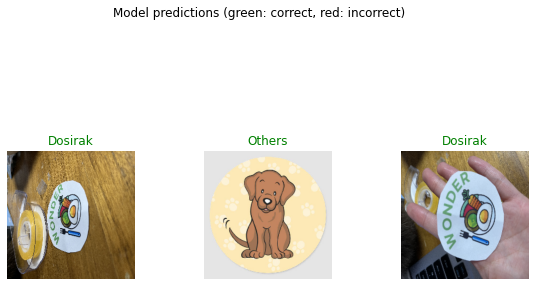

In [ ]:
plt.figure(figsize=(10,20))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels))):
  plt.subplot(6,3,n+1)
  plt.imshow(test_img[n])
  color = "green" if predicted_labels[n] == dataset_labels[true_labels[n]] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Save model as tflite

In [ ]:
model.save('my_custom_model')

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)